# FDM: Non-Dirichlet Eigenfunctions

The purpose of this script is to confirm that there are eigenfunctions belonging to the problem

\begin{align*}
    -\left( \nabla^{\theta}_{\mu} \right)^2 u = \omega^2 u,
\end{align*}

in the Cross-in-the-Plane geometry that _are not_ eigenfunctions of the Dirichlet laplacian on this domain.

We will demonstrate their existence in the following way; 
- Compute the eigenvalues near to an eigenvalues corresponding to the Dirichlet laplacian, $\omega_{n,m}^2 = (n^2+m^2)\pi^2$.
- Determine, given that the error in the eigenvalues should scale as $-2\ln(N) + c$, which eigenvalues lie outside this region and thus are not converging to $\omega_{n,m}^2$.
- Plot the corresponding eigenfunctions --- these should be the distinct functions we are looking for.

In [1]:
from datetime import datetime

import numpy as np
from numpy import pi, exp, sin

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable

from CompMes_FDM import FDM_FindEvals, RealEvalIndices, InsertSlaveNodes

In [2]:
def TranslateFDM(u):
    '''
    Translates an eigenfunction from the FDM onto the domain of the VP.
    The domains are identical, however the period cell was viewed in different ways: FDM has the central vertex at (1/2,1/2), whilst VP had the vertex at (0,0).
    As such, we need to move the entries of the vector u containing the FDM entries, so that we can view the two functions over the same reference domain.
    INPUTS:
        u: ((N-1)**2,) complex, eigenfunctions from FDM solve
    OUTPUTS:
        uShift: ((N-1)**2,) complex, eigenfunction u but now on the reference domain of VP
    '''

    # N from FDM; FDM has shape ((N-1)*(N-1),) due to the periodicity constraint
    N = int(np.sqrt( np.shape(u)[0] ) + 1)

    # FDM uses vertex at (1/2,1/2), whereas VP uses vertex at (0,0), so we need to translate by periodicity
    # this is compounded by the "repeated values" on the slave nodes in each of the arrays. So we don't want to re-insert the slave nodes just yet, as we want to translate first
    # for ease, let's move from our vector to the matrix representation
    matFDM = u.reshape(N-1,N-1)

    swaps = np.zeros_like(matFDM)
    swaps[0:N//2,0:N//2] = matFDM[N//2:,N//2:] # top right to bottom left
    swaps[N//2:,N//2:] = matFDM[0:N//2,0:N//2] # bottom right to top left
    swaps[0:N//2,N//2:] = matFDM[N//2:,0:N//2] # bottom right to top left
    swaps[N//2:,0:N//2] = matFDM[0:N//2,N//2:] # top left to bottom right

    uShift = swaps.reshape(((N-1)*(N-1),)) # replace vector of grid values
    return uShift

def Plot(u, N, levels=10, titStr=''):
    '''
    Plots an eigenfunction u from the FDM solve with N gridpoints in each dimension, using levels contour levels.
    INPUTS:
        u: ((N-1)**2,) complex, eigenfunctions from FDM solve
    OUTPUTS:
        fig, ax: matplotlib figure handles, for the figure created displaying the eigenfunction
    '''
    
    # prepare figure canvas
    fig, ax = plt.subplots(ncols=2, sharey=False)
    # adjust eigenfunction accordingly so that FDM shares VP domain
    U = TranslateFDM(u)

    x = y = np.linspace(0,1, num=N)
    U = InsertSlaveNodes(N, U, mat=True)
    for a in ax:
        a.set_aspect('equal')
        a.set_xlabel(r'$x_1$')
        a.set_ylabel(r'$x_2$')
    ax[0].set_title(r'$\Re (u)$')
    ax[1].set_title(r'$\Im (u)$')

    # if more levels than meshpoints in each dimension, could be difficult! Throw a warning
    if levels >= N:
        print('Number of contour levels exceeds or equals N!')
        
    # make contour plots
    # remember matplotlib convention! 
    # X, Y, Z triples where Z has shape (M,N) where X of shape (N,) and Y of shape (M) 
    # - need to transpose our data
    rCon = ax[0].contourf(x, y, np.real(U).T, levels=levels)
    iCon = ax[1].contourf(x, y, np.imag(U).T, levels=levels)
    
    # make colourbars
    rDiv = make_axes_locatable(ax[0])
    rCax = rDiv.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(rCon, cax=rCax)
    iDiv = make_axes_locatable(ax[1])
    iCax = iDiv.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(iCon, cax=iCax)
    
    # add title if requested
    if titStr:
        fig.suptitle(titStr)
    
    # space things out a bit better
    fig.tight_layout()
    
    return fig, ax

In [3]:
# Set run parameters
n = 1
m = 1
if n<1 or m<1:
    raise ValueError('(n,m) = (%d,%d) cannot be less than 1' % (n,m))

# Number of meshpoints to use in each dimension [must be odd]
N = 401
if N%2==0:
    raise ValueError('N must be odd!')

# Find this many eigenvalues near omega_n,m
nToFind = 10

# For saving files at the end
fOut = './'

# Value of the coupling constant at the central vertex
alpha3 = 0.

# get timestamp for saving plots later
now = fOut + 'FDM_n%d_m%d_' % (n, m) + datetime.today().strftime('%Y-%m-%d-%H-%M')

# derive values from n,m
lbda = (n*n + m*m)*pi*pi
omega = np.sqrt(lbda)

# set the quasi-momentum to the fixed value
theta = -np.pi * np.ones((2,), dtype=float)
if n%2==0:
    theta[0] = 0.
if m%2==0:
    theta[1] = 0.

In [4]:
# Perform runs with varying N to gather the data required, computing approximations from the FDM
print('   SOLVING N=%d    ' % N)
sqEvals, eVecs, _ = FDM_FindEvals(N, theta, alpha3, lOff=False, nEvals=nToFind, sigma=lbda, checks=False, \
                                      saveEvals=False, saveEvecs=False, sparseSolve=True)

   SOLVING N=401    
alpha_3 is zero: take care when solving discretised system.
Eigenvalue solving, this may take a while... finished
----- Analysis ----- 
 #E-vals found: 10
#Inf/NaN values: 0
#Real eigenvalues: 10
-----


In [6]:
# now we look for eigenfunctions that are NOT the shared Dirichlet eigenfunctions!
# The idea here is to AVOID the eigenvalue that was close to (n^2+m^2)pi^2,
# instead looking at the nearby eigenfunctions, and hope they are vastly different.
nRealEvals = RealEvalIndices(sqEvals)
if np.sum(nRealEvals)==nToFind:
    # everything was real, so convergence is good
    # cast eigenvalues to floats safely
    sqEvals = np.real(sqEvals)
else:
    # at least one eigenvalue is bad...
    raise ValueError('%d non-real eigenvalues found for N=%d' % (np.sum(nRealEvals), N))

# identify the eigenvalue found that is closest to the true lbda
sqDiffs = lbda - sqEvals
bestEvalInd = np.argmin(np.abs(sqDiffs))
# record the error in the eigenvalue
sqError = np.abs(sqDiffs[bestEvalInd])
print('N=%d: closest eigenvalue is at index %d with difference of %.5e' % (N, bestEvalInd, sqError))

N=401: closest eigenvalue is at index 0 with difference of 8.15816e-04


Found 9 (/10) eigenvalues distinct from omega_{n,m}^2
Plotting eigenfunctions close to omega_{n,m}^2...


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


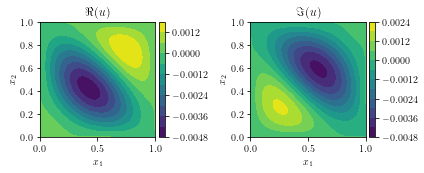

In [7]:
# determine which eigenvalues are "too close" to omega_{n,m} to be discounted as not converging to it
# the approximate error rate is ERROR = e^{C}/N^2, where
# 4.9 <= C <= 6.1 as estimated by our convergence investigations
# Be cautious and zealously remove potentially safe eigenvalues
C = 6.1

closeThreshold = exp(C)/(N*N)
notOmegaNM = np.abs(sqDiffs) > closeThreshold
print('Found %d (/%d) eigenvalues distinct from omega_{n,m}^2' % (np.sum(notOmegaNM), nToFind))

if np.sum(notOmegaNM)==0:
    raise ValueError('No eigenvalues found that are distinct from omega_{n,m}!')
else:
    print('Plotting eigenfunctions close to omega_{n,m}^2...')
    closeEFs = eVecs[:,np.logical_not(notOmegaNM)]
    for i in range(nToFind - np.sum(notOmegaNM)):
        fig, ax = Plot(closeEFs[:,i], N)
        fig.show()

In [13]:
print(np.sqrt(farEVS)/pi)

[1.09527171 1.14122828 1.14122632 2.24953349 2.39960117 2.39960123
 2.80033254 3.04995628 3.04995623]


Plotting eigenfunctions corresponding to far eigenvalues...


/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
/home/will/anaconda3/envs/PythonBasics/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using 

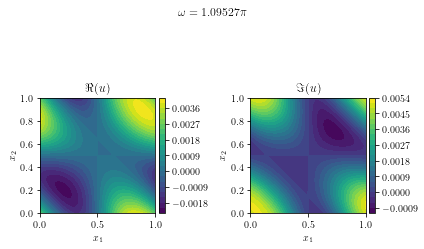

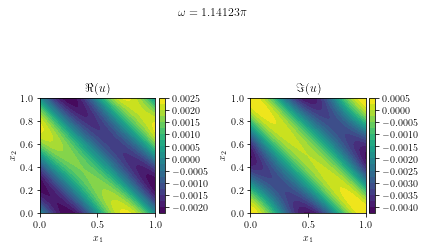

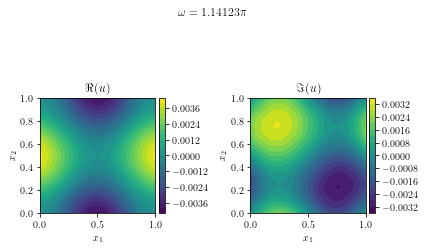

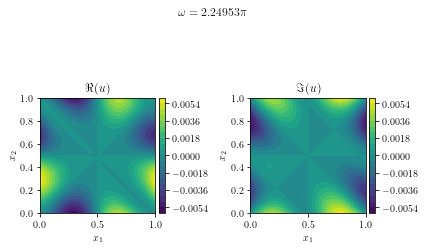

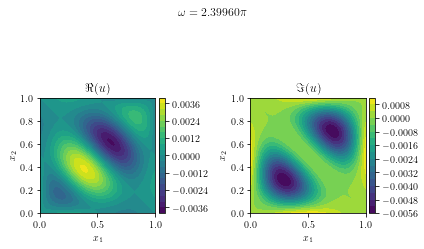

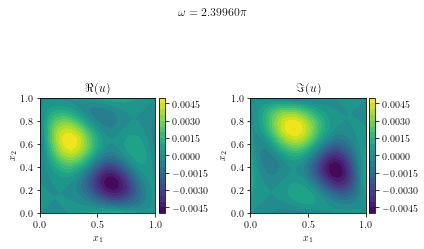

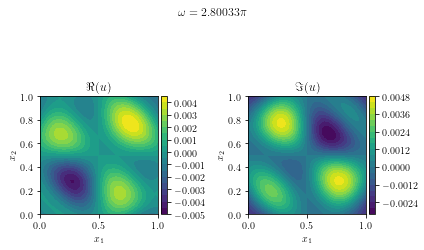

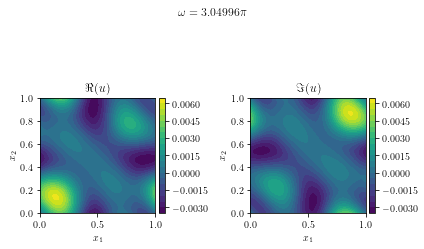

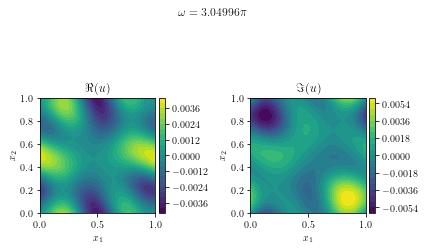

In [14]:
# now we know which eigenvalues and thus eigenfunctions are not the Dirichlet eigenfunctions
# let's plot these
farEVS = sqEvals[notOmegaNM]
farEFs = eVecs[:,notOmegaNM]

print('Plotting eigenfunctions corresponding to far eigenvalues...')
for i in range(np.sum(notOmegaNM)):
    titStr = r'$\omega = %.5f \pi$' % (np.sqrt(farEVS[i])/pi)
    f, a = Plot(farEFs[:,i], N, levels=20, titStr=titStr)
    f.show()